In [41]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
import os

In [42]:
os.environ["OPENAI_API_BASE"] = "https://openrouter.ai/api/v1"
os.environ["OPENAI_API_KEY"] = "Your Own API Key"

model = ChatOpenAI(model="deepseek/deepseek-r1:free")

In [43]:
class sentiment_schema(BaseModel):

    sentiment : Literal['positive', 'negative'] = Field(description='Sentiment of the review')

In [44]:
class diagnosis_schema(BaseModel):
    issue_type : Literal['UX', 'performance', 'bug', 'support', 'others'] = Field(description='The category of the issue mentioned in the review')
    tone : Literal['angry', 'frustrated', 'dissapointed', 'calm'] = Field(description='The emotional tone expressed by the user')
    urgency : Literal['low', 'medium', 'high'] = Field(description='How urgent or critical the issue appears to be')

In [45]:
structured_model = model.with_structured_output(sentiment_schema)
structured_model2 = model.with_structured_output(diagnosis_schema)

In [46]:
prompt = f'What is the sentiment of the following review - The software too bad'

structured_model.invoke(prompt)

sentiment_schema(sentiment='negative')

In [47]:
# define state
class review_state(TypedDict):

    review : str = Field(description='This is the review for the sentiment analysis')
    sentiment : Literal['positive', 'negetive'] = Field(description='Sentiment of the review')
    diagnosis : dict
    response : str

In [48]:
# create graph
graph = StateGraph(review_state)

In [49]:
def analyze_sentiment(state : review_state) -> review_state:

    prompt = f'For the following review find out the sentiment - \n {state["review"]}'

    sentiment = structured_model.invoke(prompt)

    return {'sentiment':sentiment}

def check_sentiment(state : review_state) -> Literal['positive_response', 'run_diagnosis']:

    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

def positive_response(state : review_state) -> review_state:

    prompt = f'''Write a warm thank you message in response to this review : \n\n {state["review"]}
\n and also , kindly ask user to leave feedback on our website.'''

    response = model.invoke(prompt)
    return{'response':response}
    
def run_diagnosis(state : review_state) -> review_state:

    prompt = f'''Run a diagnosis on the negetive review : \n\n {state["review"]}\n
resturn a issue_type, tone and urgency'''
    
    response = structured_model2.invoke(prompt)
    return{'diagnosis':response.model_dump()}

def negative_response(state : review_state) -> review_state:

    diagnosis = state['diagnosis']

    prompt = f'''You are a support assistant. The user had a {diagnosis['issue_type']} issue, 
    sounded {diagnosis['tone']}, and marked urgent {diagnosis['urgency']}\n
write an empathetic, helpful resolution message.
'''
    response = model.invoke(prompt)

    return{'response':response}

In [50]:
# add node
graph.add_node('analyze_sentiment', analyze_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)


# add edges
graph.add_edge(START, 'analyze_sentiment')
graph.add_conditional_edges('analyze_sentiment', check_sentiment)
graph.add_edge('positive_response', END)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

# compile graph
workflow = graph.compile()

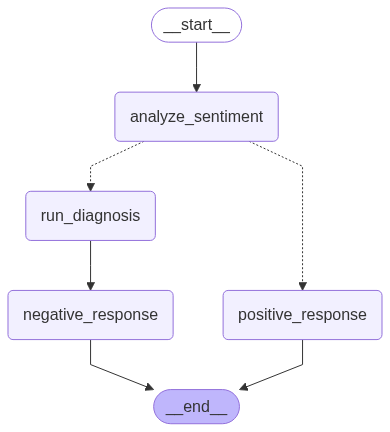

In [51]:
workflow

In [55]:
# execute graph
initial_state = {'review': 'I was really disappointed with this product. It didn’t live up to the expectations at all. The quality felt cheap, and it stopped working properly after just a few days of use. The instructions were unclear, and setup was frustrating. To make matters worse, customer support was unhelpful and slow to respond. For the price, I expected much better performance. Unfortunately, I wouldn’t recommend this to anyone.'}
workflow.invoke(initial_state)

{'review': 'I was really disappointed with this product. It didn’t live up to the expectations at all. The quality felt cheap, and it stopped working properly after just a few days of use. The instructions were unclear, and setup was frustrating. To make matters worse, customer support was unhelpful and slow to respond. For the price, I expected much better performance. Unfortunately, I wouldn’t recommend this to anyone.',
 'sentiment': sentiment_schema(sentiment='negative'),
 'diagnosis': {'issue_type': 'performance',
  'tone': 'dissapointed',
  'urgency': 'high'},
 'response': AIMessage(content='**Subject:** Re: Urgent High Priority - Performance Issue Follow-Up  \n\nHi [Name],  \n\nFirst and foremost, I’m truly sorry for the frustration and inconvenience this performance issue has caused. I completely understand how critical smooth operation is for your work, and I want to assure you that resolving this is our top priority right now.  \n\nOur team has already begun investigating the